In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from PIL import Image
from keras.layers import Dense, Input, Add, BatchNormalization, Dot
from keras.layers import Conv2D, Flatten, MaxPooling2D, Activation
from keras.layers import Reshape, Conv2DTranspose, UpSampling2D
from keras.models import Model, Sequential, model_from_json
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.losses import mae, binary_crossentropy
from keras.datasets import cifar10
from sklearn.model_selection import train_test_split
import sklearn
#from keras.utils import plot_mode
from keras import backend as K
import os
import tensorflow as tf
import tqdm.notebook as tnb
import h5py


170508288/170498071 [==============================] - 6s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)
(10, 32, 32, 3)


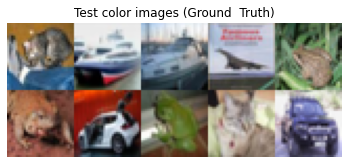

In [ ]:
# load the CIFAR10 dataset
#Split the dataset to training (50000 images) and testing (10000 images)
(x_train, y_train), (x_test, _) = cifar10.load_data()

##Printing the shape of the training and testing dataset
print(x_train.shape) # (50000, 32, 32, 3)
print(x_test.shape) # (10000, 32, 32, 3)

# input image dimensions are stored in separate variables
img_rows_count = x_train.shape[1] # Image Height
img_cols_count = x_train.shape[2] # Image width
channels = x_train.shape[3] # Depth/ Channel of Image = 3 (3 since RGB image)

# create saved_images folder
imgs_dir = 'saved_images'

## os.getcwd() - returns the current working directory, os.path.join() - joins the current working directory path to the imgs_dir
save_dir = os.path.join(os.getcwd(), imgs_dir) 

## Create the above directory if it is not created earlier
if not os.path.isdir(save_dir):
        os.makedirs(save_dir)


# display the 1st 100 input color images
imgs = x_test[:10]
print(imgs.shape)
imgs = imgs.reshape((2, 5, img_rows_count, img_cols_count, channels))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Test color images (Ground  Truth)')
plt.imshow(imgs)
plt.savefig('%s/test_color.png' % imgs_dir)
plt.show()

In [ ]:
## Function to convert RGB image to grayscale image
## All Red Channel pixels is multiplied by 0.299
## All Green Channel pixels is multiplied by 0.299
## All Blue Channel pixels is multiplied by 0.299

def rgbToGray(input_img_list):
  return np.dot(input_img_list[...,:3], [0.299, 0.587, 0.114])


def plot(A,B,C,n):

    samples = [A,B,C]
    fig = plt.figure(figsize=(3,n))
    gs = gridspec.GridSpec(3,n)
    g=0
    for i in range(3):
        for j in range(n):
            ax = plt.subplot(gs[g])
            g+=1
            plt.axis('off')
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_aspect('equal')
            if samples[i][j].shape == (32,32,1):
              plt.imshow(samples[i][j].reshape(32, 32), cmap='gray')
            else:
              plt.imshow(samples[i][j].reshape(32,32,3))

    return fig

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## AutoEncoder class to create model for Encoder and Decoder.
## It has 1 method, autoencoder model learning 3 channels (RGB)

class AutoEncoder :
  def __init__(self, input_image_size):
    print("This is the AutoEncoder Class!!")
    ##input_image_size is a tuple containing the image height, width and channels
    self.img_size = input_image_size 

    ## Latent vector size (hardcoded)
    self.__latent_dimension_size__=256 

    ## Initiating a feature image size to an empty tuple
    self.__feature_image_size__= tuple()
    #print(self.img_size)

    ## Defining the input tensor for encoder model input
    ## Input for a encoder model is a 32 x 32 image of 1 channel (grayscale)
    self.encoder_input = Input(shape = self.img_size)

    ## Defining the input tensor for decoder model input
    ## Input for a decoder model is a latent vector of dimension 256
    self.decoder_input = Input(shape = (self.__latent_dimension_size__,))

    ## Initializing the latest feature vector of AutoEncoder
    self.latent_feature_vector=np.array([])

    ## Initializing the output image to a empty numpy array
    self.output_img=np.array([])
    
  def autoencoder_model(self):
    '''
    A function to create a encoder model of the AutoEncoder class.
    It has multiple convolution layers to extract the features of the image.
    Finally the input image is reduced to a latent feature vector of dimension 256 bits.

    input to the encoder_model is a grayscale image
    output of the encoder_model is a encoder model
    '''

    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv1_1')(self.encoder_input) #output - 32 x 32 x 1
    conv1 = Conv2D(64, (3, 3), padding='same', name='conv1_2') (conv1) #output - 32 x 32 x 64
    conv1 = BatchNormalization()(conv1)
    conv1 = Activation('relu')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #output -  16 x 16 x 64
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv2_1')(pool1) #output -  16 x 16 x 128
    conv2 = Conv2D(128, (3, 3), padding='same', name='conv2_2')(conv2) #output -  16 x 16 x 128
    conv2 = BatchNormalization()(conv2)
    conv2 = Activation('relu')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #output -  8 x 8 x 128
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv3_1')(pool2) #output -  8 x 8 x 256
    conv3 = Conv2D(256, (3, 3), padding='same', name='conv3_2')(conv3) #output - 8 x 8 x 256
    conv3 = BatchNormalization()(conv3)
    conv3 = Activation('relu')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3) #output - 4 x 4 x 256
    self.__feature_image_size__ = pool3.shape ##Saving the shape in order to use it in the decoder while converting the latent vector to image
    #print(self.__feature_image_size__)

    ## The image is flattened to a vector shape. i.e, 4 x 4 x 256 image is flattened to 4096 x 1 vector
    fcn_1= Flatten()(pool3) #output - 4096

    #fcn_2=Dense(1024, activation='relu')(fcn_1)
    ## A FCN layer with 256 neurons
    self.latent_feature_vector=Dense(self.__latent_dimension_size__, activation='relu')(fcn_1) ##output - 256 bit vector

    ## Calculating the FCN layer neuron size from the latent feature image to increase the dimension of the vector from 256 to 4096 (4 x 4 x 256)
    input_neuron_size=self.__feature_image_size__[1] * self.__feature_image_size__[2] \
                * self.__feature_image_size__[3]
    #print(input_neuron_size)

    ## FCN layer to increase the dimension from 256 to 4096
    fcn_1=Dense(input_neuron_size) (self.latent_feature_vector)
    latent_feature_image = Reshape((self.__feature_image_size__[1], self.__feature_image_size__[2], \
                                    self.__feature_image_size__[3]))(fcn_1)  #output - 4 x 4 x 256
    
    #Convolution network
    up1 = UpSampling2D((2,2))(latent_feature_image) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same', name='conv4_1')(up1) #output - 8 x 8 x 256
    conv4 = Conv2D(256, (3, 3), padding='same', name='conv4_2')(conv4)
    conv4 = BatchNormalization()(conv4)
    conv4 = Activation('relu')(conv4)
    conv4 = Add()([conv4, conv3])
    up2 = UpSampling2D((2,2))(conv4) #output - 16 x 16 x 256
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same', name='conv5_1')(up2)
    conv5 = Conv2D(128, (3, 3), padding='same', name='conv5_2')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv5 = Activation('relu')(conv5)
    conv5 = Add()([conv5, conv2])
    up3 = UpSampling2D((2,2))(conv5) #32 x 32 x 128
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same', name='conv6_1')(up3)
    conv6 = Conv2D(64, (3, 3), padding='same', name='conv6_2')(conv6)
    conv6 = BatchNormalization()(conv6)
    conv6 = Activation('relu')(conv6)
    conv6 = Add()([conv6, conv1])

    ## Final image with 3 channels and input size and output size matching the input size
    decoded = Conv2D(3, (3, 3), activation='sigmoid', padding='same', name='decoded_output')(conv6)

    ## Decoder model with input as a tensor of latent feature vector of 256 but and output as a image of size 32 x 32 x 3
    autoencoder = Model(self.encoder_input, decoded, name = 'autoencoder')
    return autoencoder


In [ ]:
##Splitting the training set of 50,000 image samples to training set and validation set
X_train, X_val, _, _ = train_test_split(x_train, y_train, test_size=0.2)

## Converting all the images to grayscale
X_train_gray=rgbToGray(X_train)
X_val_gray=rgbToGray(X_val)
X_test_gray=rgbToGray(x_test)

## Normalizing the pixel values between 0 and 1
X_train_gray=X_train_gray.astype('float32') / 255
X_val_gray=X_val_gray.astype('float32') / 255
X_test_gray=X_test_gray.astype('float32') / 255

X_train = X_train.astype('float32') / 255
X_val = X_val.astype('float32') / 255

# reshape images to row x col x channel for CNN output/validation
X_train = X_train.reshape(X_train.shape[0], img_rows_count, img_cols_count, channels)
X_val = X_val.reshape(X_val.shape[0], img_rows_count, img_cols_count, channels)
x_test = x_test.reshape(x_test.shape[0], img_rows_count, img_cols_count, channels)

# reshape images to row x col x channel for CNN input
X_train_gray = X_train_gray.reshape(X_train_gray.shape[0], img_rows_count, img_cols_count, 1)
X_val_gray = X_val_gray.reshape(X_val_gray.shape[0], img_rows_count, img_cols_count, 1)
X_test_gray = X_test_gray.reshape(X_test_gray.shape[0], img_rows_count, img_cols_count, 1)

## Number of iterations the model runs
epochs = 100

## number of images considered per batch to train the model
batch_size = 32

## storing the image shape to pass as input to the encoder model
img_rows_count = X_train_gray.shape[1]
img_cols_count = X_train_gray.shape[2]
input_channels = 1

## Input shape having the shape (32, 32, 1)
input_shape=(img_rows_count, img_cols_count, input_channels)

In [ ]:
### GAN class
class GAN:
  def __init__(self, input_image_shape):
    print("This is the GAN class!!")
    self.img_shape = input_image_shape
    self.autoencoder=AutoEncoder(self.img_shape)
    self.generator_input=Input(shape=self.img_shape, name = 'Generator_input' )
    self.discriminator_input_shape = list(self.img_shape)
    self.discriminator_input_shape[-1] = 3
    self.discriminator_input_shape = tuple(self.discriminator_input_shape)
    self.discriminator_input= Input(shape = self.discriminator_input_shape, name='Discriminator_input' )

  def generator_network(self) :
    print("This is the generator network!!")

    #encoder_model=self.autoencoder.encoder_model()
    #decoder_model=self.autoencoder.decoder_model()

    autoencoder_model = self.autoencoder.autoencoder_model()
    #input_img = Input(shape = self.img_shape)

    generator = autoencoder_model

    return generator

  def discriminator_network(self):
    print("This is the discriminator network!!")

    conv1=Conv2D(64, (3,3), padding='same', activation='relu')(self.discriminator_input) # 32 x 32 x 64
    conv1=Conv2D(64, (3,3), padding='same', activation='relu', strides=2) (conv1) # 16 x 16 x 64
    conv2=Conv2D(128, (3,3), padding='same', activation='relu')(conv1) # 16 x 16 x 128
    conv2=Conv2D(128, (3,3), padding='same', activation='relu', strides=2) (conv2) # 8 x 8 x 128
    conv3=Conv2D(256, (3,3), padding='same', activation='relu')(conv2) # 8 x 8 x 256
    conv3=Conv2D(256, (3,3), padding='same', activation='relu', strides=2) (conv3) # 4 x 4 x 256

    fcn1=Flatten()(conv3) # 4096
    fcn2=Dense(1024, activation='relu')(fcn1) # 1024
    fcn3=Dense(256, activation='relu')(fcn2) # 256

    out_value=Dense(1, activation='softmax')(fcn3) # 1

    discriminator = Model(self.discriminator_input, out_value, name='discriminator_binary_classifier')

    return discriminator

  def prepare_discriminator_files(self, real_data, fake_data):
    #print("Preparing the real and fake data")
    #print("shape of real data", str(real_data.shape))
    #print("shape of fake data", str(fake_data.shape))

    y_real=tf.ones(real_data.shape[0])
    y_fake=tf.zeros(fake_data.shape[0])

    y_actual=tf.concat([y_real, y_fake], axis = 0)
    input_data=tf.concat([real_data, fake_data], axis = 0)

    #print("Label shape after concat", str(y_actual.shape))
    #print("Input data shape after concat ", str(input_data.shape))

    return input_data, y_actual
    
  def generator_containing_discriminator(self , g, d) :

    gt_image = self.discriminator_input
    reconstructed_image = g(self.generator_input)
    reconstructed_class = d(self.discriminator_input)
    d.trainable = False

    reconstructed_image = Flatten()(reconstructed_image)
    real_image = Flatten()(gt_image)

    cos_dis = Dot(axes = 1,normalize = True)([reconstructed_image, real_image])

    gan_model = Model([self.generator_input, gt_image],[reconstructed_class, cos_dis], name='GAN_combined_model')

    return gan_model


In [ ]:
input_image=(img_rows_count, img_cols_count, input_channels)
print(input_image)

gan = GAN(input_image)

generator_model = gan.generator_network()
generator_model.summary()

discriminator_model = gan.discriminator_network()
discriminator_model.summary()

d_on_g_model = gan.generator_containing_discriminator(generator_model, discriminator_model)
d_on_g_model.summary()


(32, 32, 1)
This is the GAN class!!
This is the AutoEncoder Class!!
This is the generator network!!
Model: "autoencoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv1_1 (Conv2D)                (None, 32, 32, 64)   640         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_2 (Conv2D)                (None, 32, 32, 64)   36928       conv1_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         conv1_2[0][0]         

In [ ]:
"""
=============================This COde snippet is not used==================================================
generator_input_tensor = Input(shape=input_image, name='recons_loss_input')
discriminator_input_tensor = Input(shape=(X_train.shape[1], X_train.shape[2], channels))

recons_img = generator_model(generator_input_tensor)
#recons_class = discriminator_model()

real_image_tensor = Input(shape=(X_train.shape[1], X_train.shape[2], channels))
real_class_tensor = Input(shape=(1))

recons_img= Flatten()(recons_img)
real_image_tensor = Flatten()(real_image_tensor)
print(recons_img.shape)
print(real_image_tensor.shape)
#print(recons_class.shape)
print(real_class_tensor.shape)

reconstruction_img_loss = mae(real_image_tensor, recons_img)
#reconstruction_class_loss = binary_crossentropy(real_class_tensor, recons_class)
print(reconstruction_img_loss.shape)
#print(reconstruction_class_loss.shape)

lambda_1 = 100

generator_loss = K.mean((lambda_1 * reconstruction_img_loss)) #+ reconstruction_class_loss)

print(generator_loss.shape)
"""

In [ ]:
### Design of GAN model

from keras.optimizers import Adam
adam = Adam(learning_rate=0.0002)
weights_save_path='/content/drive/MyDrive/Image_Colorization_Weights/'

batch_size = 32

#generator_model.add_loss(reconstruction_img_loss)
generator_model.compile(loss='mean_absolute_error', optimizer = 'sgd')

discriminator_model.compile(loss='binary_crossentropy', optimizer = 'adam')

d_on_g_model.compile(loss='binary_crossentropy', optimizer = 'adam')

generator_model_json = generator_model.to_json()
with open(weights_save_path+'generator_model.json', "w") as g_json_file:
    g_json_file.write(generator_model_json)

DonG_model_json = d_on_g_model.to_json()
with open(weights_save_path+'DonG_model.json', "w") as d_on_g_json_file:
    d_on_g_json_file.write(DonG_model_json)

discriminator_model_json = discriminator_model.to_json()
with open(weights_save_path+'discriminator_model.json', "w") as d_json_file:
    d_json_file.write(discriminator_model_json)

g_loss_best=1
d_loss_best=0

#generator_train = generator_model.fit(X_train_gray, X_train, validation_data=(X_val_gray, X_val) ,
#                                           epochs=epochs, batch_size=batch_size)

for epoch in range(epochs):
    print("############### Start of Epoch ######################")
    print("Epoch is", epoch)
    print("Number of batches", int(X_train.shape[0]/batch_size))
    
    for index in tnb.tqdm(range(int(X_train.shape[0]/batch_size))) :
        gray_image_batch = X_train_gray[index*batch_size:(index+1)*batch_size]
        image_batch = X_train[index*batch_size:(index+1)*batch_size]
        generated_images = generator_model.predict(gray_image_batch)
        train_image_data, label_image_data = gan.prepare_discriminator_files(image_batch, generated_images)
        #X = np.concatenate((image_batch, generated_images))
        #y = [1] * batch_size + [0] * batch_size
        #y = np.asarray(y)
        d_loss = discriminator_model.train_on_batch(train_image_data, label_image_data)
        #print("batch %d d_loss : %f" % (index, d_loss))
        gray_image_batch = X_train_gray[index*batch_size:(index+1)*batch_size]
        image_batch = X_train[index*batch_size:(index+1)*batch_size]
        discriminator_model.trainable = False
        g_loss,_,_ = d_on_g_model.train_on_batch([gray_image_batch, image_batch ], [np.ones((batch_size,1)), np.ones((batch_size,1))] )
        discriminator_model.trainable = True
        if g_loss < g_loss_best :
          generator_model.save_weights(weights_save_path+'generator_model.h5')
          g_loss_best = g_loss
        if d_loss > d_loss_best :
          discriminator_model.save_weights(weights_save_path+'discriminator_model.h5')
          d_loss_best = d_loss
        d_on_g_model.save_weights(weights_save_path+'d_on_g_model.h5')
        #print("batch %d g_loss : %f" % (index, g_loss))

    #plt.imshow(generator_model.predict([X_test_gray[6]]))
    print("batch %d d_loss : %f" % (index, d_loss))
    print("batch %d g_loss : %f" % (index, g_loss))

    plt_indices = np.random.randint(10000,size=3)
    plt_a = X_test_gray[plt_indices]
    plt_b = generator_model.predict(plt_a)
    plt_c = x_test[plt_indices]
    fig = plot(plt_a,plt_b,plt_c,3)
    plt.show()
    plt.close(fig)

    print("################ End of Epoch #######################")

In [ ]:
## This COde is can be used when the weights for the model is known 
# load json and create model
generator_json_file = open('/content/sample_data/generator_model.json', 'r')
loaded_generator_model_json = generator_json_file.read()
generator_json_file.close()
loaded_generator_model = model_from_json(loaded_generator_model_json)
# load weights into new model
loaded_generator_model.load_weights("/content/sample_data/generator_model.h5")
print("Loaded generator model from disk")

discriminator_json_file = open('/content/sample_data/discriminator_model.json', 'r')
loaded_discriminator_model_json = discriminator_json_file.read()
discriminator_json_file.close()
loaded_discriminator_model = model_from_json(loaded_discriminator_model_json)
# load weights into new model
loaded_discriminator_model.load_weights("/content/sample_data/discriminator_model.h5")
print("Loaded discriminator model from disk")

DonG_json_file = open('/content/sample_data/DonG_model.json', 'r')
loaded_DonG_model_json = DonG_json_file.read()
DonG_json_file.close()
loaded_DonG_model = model_from_json(loaded_DonG_model_json)
# load weights into new model
loaded_DonG_model.load_weights("/content/sample_data/d_on_g_model.h5")
print("Loaded DonG model from disk")
 
# evaluate loaded model on test data
#loaded_generator_model.eval()
pred = loaded_generator_model.predict(X_test_gray)

Loaded generator model from disk
Loaded discriminator model from disk
Loaded DonG model from disk


In [ ]:
pred = generator_model.predict(X_test_gray)

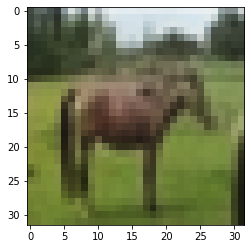

In [ ]:
plt.imshow(pred[9999])

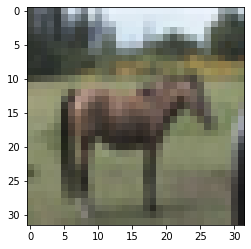

In [ ]:
plt.imshow(x_test[9999])